<a href="https://colab.research.google.com/github/francescopatane96/Computer_aided_drug_discovery_kit/blob/main/14_pocket_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install nglview biopandas

In [4]:
import io
from pathlib import Path
import time
import gzip

import requests
from matplotlib_venn import venn2
import matplotlib.pyplot as plt
import pandas as pd
from biopandas.pdb import PandasPdb
import nglview

#from opencadd.databases.klifs import setup_remote

pd.set_option("display.max_columns", 50)

In [5]:
def submit_dogsitescorer_job_with_pdbid(pdb_code, chain_id, ligand=""):
    """
    Submit PDB ID to DoGSiteScorer webserver using their API and get back URL for job location.

    Parameters
    ----------
    pdb_code : str
        4-letter valid PDB ID, e.g. '3w32'.
    chain_id : str
        Chain ID, e.g. 'A'.
    ligand : str
        Name of ligand bound to PDB structure with pdb_id, e.g. 'W32_A_1101'.
        Currently, the ligand name must be checked manually on the DoGSiteScorer website.

    Returns
    -------
    str
        Job location URL for submitted query.

    References
    ----------
    Function is adapted from: https://github.com/volkamerlab/TeachOpenCADD/pull/3 (@jaimergp)
    """

    # Submit job to proteins.plus
    # For details on parameters see: https://proteins.plus/help/dogsite_rest
    r = requests.post(
        "https://proteins.plus/api/dogsite_rest",
        json={
            "dogsite": {
                "pdbCode": pdb_code,  # PDB code of protein
                "analysisDetail": "1",  # 1 = include subpockets in results
                "bindingSitePredictionGranularity": "1",  # 1 = include drugablity scores
                "ligand": ligand,  # if name is specified, ligand coverage is calculated
                "chain": chain_id,  # if chain is specified, calculation is only performed on this chain
            }
        },
        headers={"Content-type": "application/json", "Accept": "application/json"},
    )

    r.raise_for_status()

    return r.json()["location"]

In [6]:
pdb_id = "3w32"
chain_id = "A"
# Ligand id manually looked-up from DoGSiteScorer within proteins.plus
# Note that it is generally composed of [pdb_lig_id]_[chain_id]_[pdb_residue_id]
ligand_id = "W32_A_1101"

In [7]:
job_location = submit_dogsitescorer_job_with_pdbid(pdb_id, chain_id, ligand_id)
job_location

'https://proteins.plus/api/dogsite_rest/twNQ4AjQiuzoUUMsSdA3NxH4'

In [8]:
def get_dogsitescorer_metadata(job_location, attempts=30):
    """
    Get results from a DoGSiteScorer query, i.e., the binding sites which are found over the protein surface,
    in the form of a table with the details about all detected pockets.

    Parameters
    ----------
    job_location : str
        Consists of the location of a finished DoGSiteScorer job on the proteins.plus web server.
    attempts : int
        The time waiting for the feedback from DoGSiteScorer service.

    Returns
    -------
    pandas.DataFrame
        Table with metadata on detected binding sites.
    """

    print(f"Querying for job at URL {job_location}...", end="")

    while attempts:
        # Get job results
        result = requests.get(job_location)
        result.raise_for_status()
        # Get URL of result table file
        response = result.json()
        if "result_table" in response:
            result_file = response["result_table"]
            break
        attempts -= 1
        print(".", end="")
        time.sleep(10)
    # Get result table (as string)
    result_table = requests.get(result_file).text
    # Load the table (csv format using "\t" as separator) with pandas DataFrame
    # We cannot load the table from a string directly but from a file
    # Use io.StringIO to wrap this string as file-like object as needed for read_csv method
    # See more: https://docs.python.org/3/library/io.html#io.StringIO
    result_table_df = pd.read_csv(io.StringIO(result_table), sep="\t").set_index("name")

    return result_table_df

In [9]:
metadata = get_dogsitescorer_metadata(job_location)
metadata.head()

Querying for job at URL https://proteins.plus/api/dogsite_rest/twNQ4AjQiuzoUUMsSdA3NxH4...

,lig_cov,poc_cov,lig_name,volume,enclosure,surface,depth,surf/vol,lid/hull,ellVol,ell c/a,ell b/a,siteAtms,accept,donor,hydrophobic_interactions,hydrophobicity,metal,Cs,Ns,Os,Ss,Xs,negAA,posAA,polarAA,apolarAA,ALA,ARG,ASN,ASP,CYS,GLN,GLU,GLY,HIS,ILE,LEU,LYS,MET,PHE,PRO,SER,THR,TRP,TYR,VAL,simpleScore,drugScore
name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
P_0,85.48,31.22,W32_A_1101,1422.66,0.10,1673.75,19.26,1.176493,-,-,0.13,0.67,288,86,40,71,0.36,0,198,45,41,4,0,0.10,0.13,0.24,0.53,4,5,2,5,2,2,1,5,0,3,12,3,2,3,3,1,2,1,1,5,0.63,0.810023
P_0_0,85.48,73.90,W32_A_1101,599.23,0.06,540.06,17.51,0.901257,-,-,0.14,0.22,131,35,13,25,0.34,0,95,16,17,3,0,0.03,0.10,0.28,0.59,1,2,1,1,2,1,0,2,0,2,7,1,2,2,1,0,2,0,0,2,0.59,0.620201
P_0_1,3.23,0.44,W32_A_1101,201.73,0.08,381.07,11.36,1.889010,-,-,0.17,0.25,51,17,9,10,0.28,0,36,6,7,2,0,0.08,0.17,0.25,0.50,1,1,0,1,1,1,0,0,0,0,3,1,1,0,0,0,1,0,0,1,0.17,0.174816
P_0_2,0.00,0.00,W32_A_1101,185.60,0.17,282.00,9.35,1.519397,-,-,0.45,0.55,48,17,8,12,0.32,0,31,8,8,1,0,0.17,0.25,0.08,0.50,0,2,0,1,0,0,1,1,0,0,2,1,1,1,0,0,0,0,0,2,0.13,0.195695
P_0_3,6.45,0.29,W32_A_1101,175.30,0.15,297.42,9.29,1.696634,-,-,0.23,0.37,48,16,8,14,0.37,0,32,8,8,0,0,0.14,0.14,0.36,0.36,1,1,1,2,0,0,0,3,0,0,1,1,0,1,1,1,0,0,0,1,0.13,0.168845


In [10]:
metadata = metadata[
    [
        "lig_cov",
        "poc_cov",
        "lig_name",
        "volume",
        "enclosure",
        "surface",
        "depth",
        "surf/vol",
        "accept",
        "donor",
        "hydrophobic_interactions",
        "hydrophobicity",
        "metal",
        "simpleScore",
        "drugScore",
    ]
]

In [11]:
metadata.sort_values(by=["lig_cov", "poc_cov"], ascending=False).head()
# NBVAL_CHECK_OUTPUT

,lig_cov,poc_cov,lig_name,volume,enclosure,surface,depth,surf/vol,accept,donor,hydrophobic_interactions,hydrophobicity,metal,simpleScore,drugScore
name,,,,,,,,,,,,,,,
P_0_0,85.48,73.90,W32_A_1101,599.23,0.06,540.06,17.51,0.901257,35,13,25,0.34,0,0.59,0.620201
P_0,85.48,31.22,W32_A_1101,1422.66,0.10,1673.75,19.26,1.176493,86,40,71,0.36,0,0.63,0.810023
P_0_3,6.45,0.29,W32_A_1101,175.30,0.15,297.42,9.29,1.696634,16,8,14,0.37,0,0.13,0.168845
P_0_1,3.23,0.44,W32_A_1101,201.73,0.08,381.07,11.36,1.889010,17,9,10,0.28,0,0.17,0.174816
P_0_2,0.00,0.00,W32_A_1101,185.60,0.17,282.00,9.35,1.519397,17,8,12,0.32,0,0.13,0.195695


In [12]:
def select_best_pocket(metadata, sorted_by="drugScore"):
    """
    This function uses the defined sorting parameter to identify
    the best pocket among the obtained pockets.

    Parameters
    ----------
    metadata : pd.DataFrame
        Pockets retrieved from the DoGSiteScorer website

    by : str
        Method name(s) to sort table by (default is to sort by drugScore).

    Returns
    -------
    str
        Best binding site name.
    """

    by_methods = ["drugScore", "volume", "simpleScore", "lig_cov", "poc_cov"]

    # Sort by the selected method
    if all(elem in by_methods for elem in sorted_by):
        sorted_pocket = metadata.sort_values(sorted_by, ascending=False)
    else:
        raise ValueError(f'Selection method not in list: {", ".join(by_methods)}')

    # Get name of best pocket
    best_pocket_name = sorted_pocket.iloc[0, :].name

    return best_pocket_name

In [13]:
best_pocket_id = select_best_pocket(metadata, ["lig_cov", "poc_cov"])
best_pocket_id
# NBVAL_CHECK_OUTPUT

'P_0_0'

In [14]:
def get_url_for_pockets(job_location, file_type="pdb"):
    """
    Get all pocket file locations for a finished DoGSiteScorer job
    for a selected file type (pdb/ccp4).

    Parameters
    ----------
    job_location : str
        URL of finished job submitted to the DoGSiteScorer web server.
    file_type : str
        Type of file to be returned (pdb/ccp4).

    Returns
    -------
    list
        List of all respective pocket file URLs.
    """

    # Get job results
    result = requests.get(job_location)

    if file_type == "pdb":
        # Get pocket residues
        return result.json()["residues"]
    elif file_type == "ccp4":
        # Get pocket volumes
        return result.json()["pockets"]
    else:
        raise ValueError(f"File type {file_type} not available.")

In [15]:
def get_selected_pocket_location(job_location, best_pocket, file_type="pdb"):
    """
    Get the selected binding site file location.

    Parameters
    ----------
    job_location : str
        URL of finished job submitted to the DoGSiteScorer web server.
    best_pocket : str
        Selected pocket id.
    file_type : str
        Type of file to be returned (pdb/ccp4).

    Returns
    ------
    str
        URL of selected pocket file on the DoGSiteScorer web server.
    """
    result = []

    # Get URL for all available pdb or ccp4 files
    pocket_files = get_url_for_pockets(job_location, file_type)

    for pocket_file in pocket_files:
        if file_type == "pdb":
            if f"{best_pocket}_res" in pocket_file:
                result.append(pocket_file)
        elif file_type == "ccp4":
            if f"{best_pocket}_gpsAll" in pocket_file:
                result.append(pocket_file)

    if len(result) > 1:
        raise TypeError(f'Multiple strings detected: {", ".join(result)}.')
    elif len(result) == 0:
        raise TypeError(f"No string detected.")
    else:
        pass

    return result[0]

In [16]:
selected_pocket_residues_url = get_selected_pocket_location(job_location, best_pocket_id, "pdb")
selected_pocket_residues_url

'https://proteins.plus/results/dogsite/twNQ4AjQiuzoUUMsSdA3NxH4/3w32_P_0_0_res.pdb'

In [17]:
metadata.loc[best_pocket_id]
# NBVAL_CHECK_OUTPUT

lig_cov                          85.48
poc_cov                           73.9
lig_name                    W32_A_1101
volume                          599.23
enclosure                         0.06
surface                         540.06
depth                            17.51
surf/vol                      0.901257
accept                              35
donor                               13
hydrophobic_interactions            25
hydrophobicity                    0.34
metal                                0
simpleScore                       0.59
drugScore                     0.620201
Name: P_0_0, dtype: object

In [18]:
selected_pocket_volume_url = get_selected_pocket_location(job_location, best_pocket_id, "ccp4")
selected_pocket_volume_url

'https://proteins.plus/results/dogsite/twNQ4AjQiuzoUUMsSdA3NxH4/3w32_P_0_0_gpsAll.ccp4.gz'

In [19]:
r = requests.get(selected_pocket_volume_url)
r.raise_for_status()
# Decompress response content and wrap it in a file-like object
memfile = io.BytesIO(gzip.decompress(r.content))

In [21]:
from google.colab import output
output.enable_custom_widget_manager()

In [22]:
viewer = nglview.show_pdbid(pdb_id)
# Since we are passing bytes with no path or extension
# we need to tell nglview what kind of data this is: ccp4
viewer.add_component(memfile, ext="ccp4")
viewer.center()
viewer

NGLWidget()

In [23]:
viewer.render_image(trim=True, factor=2);

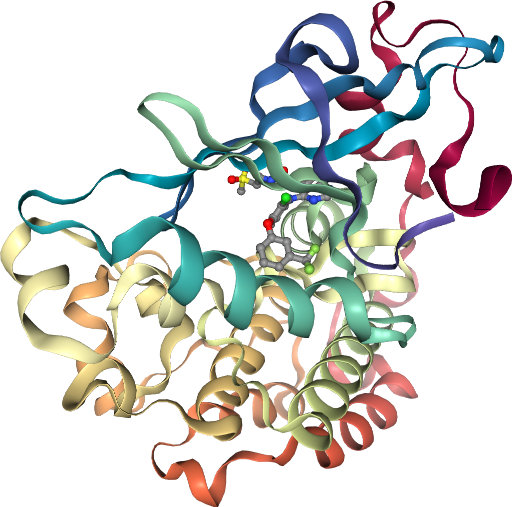

In [24]:
viewer._display_image()

In [ ]:
from google.colab import output
output.disable_custom_widget_manager()

In [25]:
def get_pocket_residues(pocket_url):
    """
    Gets residue IDs and names of a specified pocket (via URL).

    Parameters
    ----------
    pocket_url : str
        URL of selected pocket file on the DoGSiteScorer web server.

    Returns
    -------
    pandas.DataFrame
        Table of residues names and IDs for the selected binding site.
    """

    # Retrieve PDB file content from URL
    result = requests.get(pocket_url)

    # Get content of PDB file
    pdb_residues = result.text

    # Load PDB format as DataFrame
    ppdb = PandasPdb().read_pdb_from_list(pdb_residues.splitlines(True))
    pdb_df = ppdb.df["ATOM"]

    # Drop duplicates
    # PDB file contains per atom entries, we only need per residue info
    pdb_df.sort_values("residue_number", inplace=True)
    pdb_df.drop_duplicates(subset="residue_number", keep="first", inplace=True)

    return pdb_df[["residue_number", "residue_name"]]

In [27]:
dogsite_pocket_residues_df = get_pocket_residues(selected_pocket_residues_url)
dogsite_pocket_residues_df.head(10)
# NBVAL_CHECK_OUTPUT

,residue_number,residue_name
0,718,LEU
4,726,VAL
11,743,ALA
12,744,ILE
20,745,LYS
22,766,MET
29,769,VAL
34,775,CYS
35,776,ARG
45,777,LEU


In [28]:
# Show protein structure as cartoon
viewer = nglview.show_pdbid(pdb_id)
# Select pocket residues
selection = (
    f":{chain_id} and ({' or '.join(dogsite_pocket_residues_df['residue_number'].astype(str))})"
)
# Show pocket residues as stick
viewer.add_representation("ball+stick", selection=selection, aspectRatio=1.0)
# Show ligand as ball and stick
viewer.add_representation("ball+stick", selection=ligand_id.split("_")[0])
viewer.center()
viewer

NGLWidget()

In [ ]:
viewer.render_image(trim=True, factor=2);

In [ ]:
viewer._display_image()

In [ ]:
pip install git+https://github.com/volkamerlab/opencadd

In [ ]:
pip install bravado rdkit

In [39]:
from opencadd.databases.klifs import setup_remote

In [41]:
session = setup_remote()

In [42]:
# Get first structure KLIFS ID associated with PDB ID
structures = session.structures.by_structure_pdb_id(pdb_id)
structure_klifs_id = structures["structure.klifs_id"].iloc[0]

In [43]:
# Get the structure's pocket
klifs_pocket_df = session.pockets.by_structure_klifs_id(structure_klifs_id)
# Residue ID: Cast string to int
klifs_pocket_df = klifs_pocket_df.astype({"residue.id": int})
klifs_pocket_df.head()
# NBVAL_CHECK_OUTPUT

,residue.klifs_id,residue.id,residue.klifs_region_id,residue.klifs_region,residue.klifs_color
0,1,716,I.1,I,khaki
1,2,717,I.2,I,khaki
2,3,718,I.3,I,khaki
3,4,719,g.l.4,g.l,green
4,5,720,g.l.5,g.l,green


In [44]:
# Get DoGSiteScorer pocket residues as list
dogsite_pocket_residues = dogsite_pocket_residues_df["residue_number"].to_list()
print(
    f"DoGSiteScorer pocket {best_pocket_id} with {len(dogsite_pocket_residues)} residues detected."
)
# Get KLIFS pocket residues as list
klifs_pocket_residues = klifs_pocket_df["residue.id"].to_list()
print(f"KLIFS pocket with {len(klifs_pocket_residues)} residues detected.")

DoGSiteScorer pocket P_0_0 with 29 residues detected.
KLIFS pocket with 85 residues detected.


In [45]:
overlap = set.intersection(set(dogsite_pocket_residues), set(klifs_pocket_residues))
print(f"Overlap between the two residue sets: {len(overlap)}.")
# NBVAL_CHECK_OUTPUT

Overlap between the two residue sets: 27.


Residue overlap between the two methods using P_0_0.


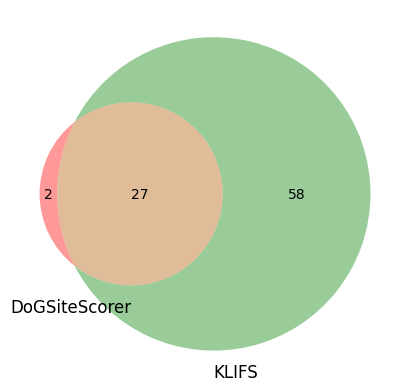

In [46]:
print(f"Residue overlap between the two methods using {best_pocket_id}.")
venn2(
    [set(dogsite_pocket_residues), set(klifs_pocket_residues)],
    set_labels=("DoGSiteScorer", "KLIFS"),
)
plt.show()

In [47]:
# Get info for largest DoGSiteScorer pocket P_0
new_pocket_id = "P_0"
dogsite_pocket_residues_df_p0 = get_pocket_residues(
    get_selected_pocket_location(job_location, new_pocket_id)
)
dogsite_pocket_residues_p0 = dogsite_pocket_residues_df_p0["residue_number"].to_list()
print(f"DoGSiteScorer pocket {new_pocket_id} with {len(dogsite_pocket_residues_p0)} detected.")
# NBVAL_CHECK_OUTPUT

DoGSiteScorer pocket P_0 with 62 detected.


Residue overlap between the two methods using P_0.


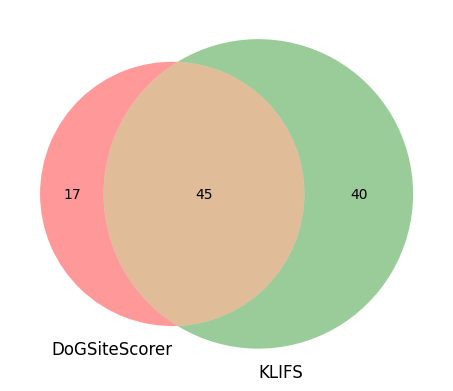

In [48]:
print(f"Residue overlap between the two methods using {new_pocket_id}.")
venn2(
    [set(dogsite_pocket_residues_p0), set(klifs_pocket_residues)],
    set_labels=("DoGSiteScorer", "KLIFS"),
)
plt.show()